# Analisis Sentimen pada Tweet Ulasan Film


- Author: Rijal Ghodi
- Email: rijalgdev@gmail.com
- Github: https://github.com/rijalghodi

<img src="https://img.freepik.com/free-photo/view-3d-cinema-elements_23-2150720822.jpg" width=400>

## Tujuan
Tujuan proyek ini adalah untuk membangun model dengan akurasi terbaik untuk memprediksi sentimen yang terkandung pada tweet ulasan film

## Dataset
Dataset dapat di-download [di sini](https://raw.githubusercontent.com/rijalghodi/datasets/main/movie_review.csv)

## Fitur-Fitur Dataset
**Dataset Features:**
- `id`: identifier unik setiap tweet
- `Sentiment`: Label sentimen (negative, positive, neutral) atas film
- `Text Tweet`: Teks tweet yang mengulas film


# Stategi Pembangunan Model

1. **Persiapan Awal**: Memulai dengan mengimpor library yang diperlukan dan memuat dataset ke dalam lingkungan kerja.

2. **Analisis Data Eksploratif (EDA)**: Untuk memahami statistik dasar dari dataset, seperti distribusi variabel, hubungan antar variabel, dan anomali potensial.

3. **Feature Engineering**: Tahap penting ini melibatkan pre-processing teks dan mengkodekan label.

4. **Pembangunan Model Dasar (Baseline)**: Membuat model awal yang sederhana.

5. **Optimisasi Hyperparameter**: Proses ini melibatkan penyetelan parameter-model (hyperparameters) untuk mencapai kinerja optimal. Metode seperti pencarian grid atau pencarian acak digunakan untuk menemukan kombinasi parameter terbaik.

6. **Implementasi dan Demo**: Terakhir, model yang telah dibangun akan diimplementasikan dan diuji menggunakan data ulasan film nyata untuk memvalidasi kinerjanya dalam konteks yang relevan.

# Persiapan - Import Libraries

In [200]:
!pip install Sastrawi

In [201]:
# Standard library for data sciene
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Library for text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer

# Library for basic machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator

# Library for deep learning
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Persiapan - Load Dataset

In [202]:
df = pd.read_csv("https://raw.githubusercontent.com/rijalghodi/datasets/main/movie_review.csv")

In [203]:
df.head()

,Id,Sentiment,Text Tweet
0,1,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,negative,Film king Arthur ini film paling jelek dari se...
2,3,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,negative,Ane ga suka fast and furious..menurutku kok je...
4,5,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


# EDA

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          200 non-null    int64 
 1   Sentiment   200 non-null    object
 2   Text Tweet  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


Dataset terdiri dari 200 entri tanpa entri null. 

Setiap baris terdiri dari kolom id, sentimen, dan text tweet

Masing-masing kolom memiliiki tipe data yang sudah sesuai

## Sentiment Distribution

<Axes: xlabel='Sentiment', ylabel='count'>

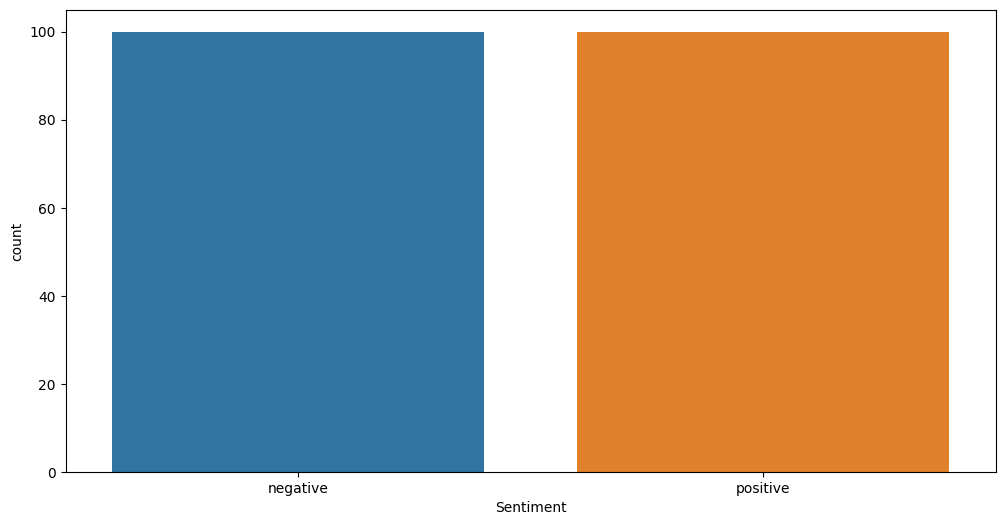

In [205]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=df)

Distribusi sentimen positif dan negatif tampak seimbang di dalam dataset

# Feature Engineering - Label Encoding

Untuk dapat melakukan classification, kita harus meng-kode target variable yakni kolom sentimen.

In [206]:
# Create a mapping dictionary
sentiment_mapping = {"positive": 1, "negative": 0}

# Map the labels to numerical values using the mapping dictionary
df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

In [207]:
df.head()

,Id,Sentiment,Text Tweet
0,1,0,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,0,Film king Arthur ini film paling jelek dari se...
2,3,0,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,0,Ane ga suka fast and furious..menurutku kok je...
4,5,0,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


# Feature Engineering - Text Preprocessing

Text pre-processing adalah serangkaian teknik untuk membersihkan, mengubah format, dan mengubah teks mentah menjadi representasi yang lebih terstruktur dan dapat diolah dengan mudah dan efisien.

Langkah-langkah yang digunakan dalam melakukan text preprocessing adalah sebagai berikut:
- Cleaning text
- Lowercase
- Remove stopwords
- Stemming / Lemmatization
- Tokenization

## Cleaning Text

Tahap ini menghilangkan teks-teks yang tidak relevan, seperti link, tagar, tanda baca, emoji, dan mengubah semua huruf menjadi huruf kecil

In [208]:
def cleaning_text(text):
    # remove url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)

    # remove mention handle user (@)
    text = re.sub(r'@[\w]*', ' ', text)

    # remove emojis
    emoji_pattern = re.compile(
        '['
        '\U0001F600-\U0001F64F'  # emoticons
        '\U0001F300-\U0001F5FF'  # symbols & pictographs
        '\U0001F680-\U0001F6FF'  # transport & map symbols
        '\U0001F700-\U0001F77F'  # alchemical symbols
        '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        '\U0001FA00-\U0001FA6F'  # Chess Symbols
        '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        '\U00002702-\U000027B0'  # Dingbats
        '\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    # remove punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, " ")

    # remove extra whitespace
    text = ' '.join(text.split())

    # lowercase
    text = text.lower()
    return text

## Menghilangkan Stopword

Stopword adalah kata-kata yang umumnya diabaikan dalam proses analisis teks karena kurangnya informasi atau makna yang signifikan. Contohnya, dalam bahasa Indonesia, kata-kata seperti "dan", "atau", "yang", dan "di". Untuk menghasilkan model yang efisien dan akurat, kita harus menghilangkan stopword.

In [209]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import requests

# CONSTRUCT STOPWORDS
rama_stopword = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/stopword.txt"
yutomo_stopword = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
fpmipa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/fpmipa-stopwords.txt"
sastrawi_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
aliakbar_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/aliakbars-bilp.txt"
pebahasa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/pebbie-pebahasa.txt"
elang_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-id.txt"
nltk_stopword = stopwords.words('indonesian')

# create path url for each stopword
path_stopwords = [rama_stopword, yutomo_stopword, fpmipa_stopword, sastrawi_stopword,
                  aliakbar_stopword, pebahasa_stopword, elang_stopword]

# combine stopwords
stopwords_l = nltk_stopword
for path in path_stopwords:
    response = requests.get(path)
    stopwords_l += response.text.split('\n')

custom_st = '''
yg yang dgn ane smpai bgt gua gwa si tu ama utk udh btw
ntar lol ttg emg aj aja tll sy sih kalo nya trsa mnrt nih
ma dr ajaa tp akan bs bikin kta pas pdahl bnyak guys abis tnx
bang banget nang mas amat bangettt tjoy hemm haha sllu hrs lanjut
bgtu sbnrnya trjadi bgtu pdhl sm plg skrg
'''

# create dictionary with unique stopword
st_words = set(stopwords_l)
custom_stopword = set(custom_st.split())

# result stopwords
stop_words = st_words | custom_stopword
print(f'Stopwords: {list(stop_words)[:5]}')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Stopwords: ['diungkapkan', 'antar', 'sempat', 'anda', 'agak']


In [210]:
# remove stopwords
from nltk import word_tokenize, sent_tokenize

def remove_stopword(text, stop_words=stop_words):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

## Stemming / Lemmatization
Stemming: Ini adalah proses normalisasi kata dengan menghapus imbuhan (affixes) dari kata untuk menghasilkan bentuk dasar, yang disebut lemma. Contohnya, kata "berlari" dan "menemukan" akan disederhanakan menjadi "lari", "temu".

Lemmatization juga merupakan proses normalisasi kata-kata, tetapi lebih kompleks daripada stemming karena melibatkan analisis morfologi kata-kata untuk mengembalikan kata-kata ke bentuk dasarnya, yang disebut "lemma". Contohnya, kata "mempertanggung-jawabkan" akan disederahanakan menjadi "tanggung-jawab"

Keduanya seringkali menghasilkan kata dasar yang sama tapi dalam beberapa kasus menghasilkan perbedaan. 


In [211]:
# stemming and lemmatization
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming_and_lemmatization(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

## Tokenization

proses memecah teks atau korpus menjadi unit-unit yang lebih kecil, yang disebut dengan token. Token-token ini bisa berupa kata, frasa, simbol, atau unsur-unsur lain yang memiliki makna, tergantung pada konteks dan kebutuhan dari tugas yang sedang dilakukan. 

Tokenisasi merupakan langkah penting dalam pemrosesan bahasa alami (NLP) dan analisis teks, karena memungkinkan komputer untuk memahami dan memproses data teks secara lebih efektif.

In [212]:
# tokenization
def tokenize(text):
    return word_tokenize(text)

## Gabungkan Semua Step Pre-Processing 


In [213]:
# example
text = 'Jelek filmnya... apalagi si ernest gak mutu bgt actingnya... film sampah 💩 #kecewa https://x.com/alnurulg/status/1761301921846140991?s=20'
print(f'Original text: \n{text}\n')

# cleaning text and lowercase
text = cleaning_text(text)
print(f'Cleaned text: \n{text}\n')

# remove stopwords
text = remove_stopword(text)
print(f'Removed stopword: \n{text}\n')

# stemming and lemmatization
text = stemming_and_lemmatization(text)
print(f'Stemmed and lemmatized: \n{text}\n')

# tokenization
text = tokenize(text)
print(f'Tokenized: \n{text}')

Original text: 
Jelek filmnya... apalagi si ernest gak mutu bgt actingnya... film sampah 💩 #kecewa https://x.com/alnurulg/status/1761301921846140991?s=20

Cleaned text: 
jelek filmnya apalagi si ernest gak mutu bgt actingnya film sampah kecewa

Removed stopword: 
jelek filmnya ernest gak mutu actingnya film sampah kecewa

Stemmed and lemmatized: 
jelek film ernest gak mutu actingnya film sampah kecewa

Tokenized: 
['jelek', 'film', 'ernest', 'gak', 'mutu', 'actingnya', 'film', 'sampah', 'kecewa']


## Terapkan ke Dataset

In [214]:
# pipeline preprocess
def preprocess(text):
    # cleaning text and lowercase
    output = cleaning_text(text)

    # remove stopwords
    output = remove_stopword(output)

    # stemming and lemmatization
    output = stemming_and_lemmatization(output)

    # tokenization - Kita hapus dulu tokenisasi
    # output = tokenize(output)

    return output

In [215]:
# implement preprocessing
preprocessed_df = df.copy()
preprocessed_df['Preprocessed'] = df['Text Tweet'].map(preprocess)

In [216]:
preprocessed_df.tail()

,Id,Sentiment,Text Tweet,Preprocessed
195,196,1,Fargo juga adaptasi dari film yang cukup berha...,fargo adaptasi film hasil season 1 best
196,197,1,637.000 waw ini sangat keren flm horor dng jum...,637 000 waw keren flm horor dng tonton gin dlm 4
197,198,1,@filmziarah film yang tenang dan menghanyutkan...,film tenang hanyut salut mbah ponco bawa karak...
198,199,1,Film yg amat menarik. Kisah cinta & kesetiaan ...,film tarik kisah cinta setia saji kgn nenek re...
199,200,1,"Nntn @filmziarah , film bagus, ada kali 5 meni...",nntn film bagus 5 menit tonton gak anjak tetep...


In [217]:
# Save into file csv
csv_file_path = 'preprocessed_moview_review.csv'
preprocessed_df.to_csv(csv_file_path, sep=',', index=False, header=True)

print(f'Data has been saved to {csv_file_path}')

Data has been saved to preprocessed_moview_review.csv


In [218]:
# load dataset into pandas
import pandas as pd
data = pd.read_csv('preprocessed_moview_review.csv')
data

,Id,Sentiment,Text Tweet,Preprocessed
0,1,0,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek film ernest gak mutu actingnya film sampah
1,2,0,Film king Arthur ini film paling jelek dari se...,film king arthur film jelek cerita king arthur
2,3,0,@beexkuanlin Sepanjang film gwa berkata kasar ...,film kasar bapak
3,4,0,Ane ga suka fast and furious..menurutku kok je...,ga suka fast and furious turut jelek film
4,5,0,"@baekhyun36 kan gua ga tau film nya, lu bilang...",ga tau film bilang perang perang perang an rp ...
...,...,...,...,...
195,196,1,Fargo juga adaptasi dari film yang cukup berha...,fargo adaptasi film hasil season 1 best
196,197,1,637.000 waw ini sangat keren flm horor dng jum...,637 000 waw keren flm horor dng tonton gin dlm 4
197,198,1,@filmziarah film yang tenang dan menghanyutkan...,film tenang hanyut salut mbah ponco bawa karak...
198,199,1,Film yg amat menarik. Kisah cinta & kesetiaan ...,film tarik kisah cinta setia saji kgn nenek re...


# Membangun Model Dasar - Persiapan Data Training dan Test



In [219]:
# Assuming your data is in a CSV file
file_path = 'preprocessed_moview_review.csv'
df = pd.read_csv(file_path)

# Assuming the 'Text Tweet' column contains the text data and 'Sentiment' contains labels
texts = df['Preprocessed'].values
labels = df['Sentiment'].values

In [220]:
texts[0]

'jelek film ernest gak mutu actingnya film sampah'

In [221]:
# Tokenize the text data
MAX_WORDS = 10000  # Adjust based on your dataset size
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [222]:
sequences[0:3]

[[8, 1, 209, 13, 106, 210, 1, 211],
 [1, 41, 42, 1, 8, 14, 41, 42],
 [1, 212, 213]]

In [223]:
# Pad sequences to make them of equal length
max_sequence_length = 100  # Adjust based on your dataset and sequence length
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [224]:
data

array([[  0,   0,   0, ..., 210,   1, 211],
       [  0,   0,   0, ...,  14,  41,  42],
       [  0,   0,   0, ...,   1, 212, 213],
       ...,
       [  0,   0,   0, ...,  29, 179, 196],
       [  0,   0,   0, ..., 176, 105, 773],
       [  0,   0,   0, ..., 208, 777, 129]], dtype=int32)

In [225]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [226]:
X_train

array([[  0,   0,   0, ..., 143, 411,   1],
       [  0,   0,   0, ...,  29, 179, 196],
       [  0,   0,   0, ...,  25,  10, 106],
       ...,
       [  0,   0,   0, ..., 439, 440,  91],
       [  0,   0,   0, ...,   9, 103,   3],
       [  0,   0,   0, ...,   3, 132, 474]], dtype=int32)

In [227]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((160, 100), (160,), (40, 100), (40,))

# Membangun Model Dasar - Deep Learning + LSTM

Masalah yang dihadapi adalah klasifikasi teks. Oleh karena itu, kita akan menggunakan deep learning untuk menyelesaikannya.

Karena teks adalah data sekuen yang sangat sensitif terhadap urutan, kita akan menggunakan layer LSTM dalam deep learning untuk membangun model dengan akurasi yang tinggi.

Untuk model dasar ini, kita akan menggunakan konfigurasi sebagai berikut:
- Layer embedding dengan input_dim = 1000 dan output_dim = 100.
- Layer LSTM dengan units = 64, dropouts = 0.2, dan recurrent_dropout = 0.2.
- Layer output dengan 1 neuron dan fungsi aktivasi softmax.


In [228]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [229]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=100))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='softmax'))

In [230]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [231]:
model.summary()

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_69 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [232]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5143 - loss: 0.0000e+00

/opt/conda/lib/python3.10/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.5129 - loss: 0.0000e+00 - val_accuracy: 0.4750 - val_loss: 0.0000e+00
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5290 - loss: 0.0000e+00 - val_accuracy: 0.4750 - val_loss: 0.0000e+00
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.4999 - loss: 0.0000e+00 - val_accuracy: 0.4750 - val_loss: 0.0000e+00
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5273 - loss: 0.0000e+00 - val_accuracy: 0.4750 - val_loss: 0.0000e+00
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5442 - loss: 0.0000e+00 - val_accuracy: 0.4750 - val_loss: 0.0000e+00
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5247 - loss: 0.0000e+00 - val_accuracy: 0.4750 - val_loss: 0.0000e+00
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4990 - loss: 0.0000e+00 - val_accuracy: 0.4750 - val_loss: 0.0000e+00
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.48

In [233]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_train, y_train)

print("Train Loss:", loss)
print("Train Accuracy:", accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4986 - loss: 0.0000e+00
Train Loss: 0.0
Train Accuracy: 0.5062500238418579


In [234]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4625 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 0.4749999940395355


**Kesimpulan Akurasi Model Dasar**

Baik dataset train dan test memiliki akurasi yang sangat rendah (50% dan 47%).
Untuk meningkatkan akurasi kita perlu melakukan tuning.

# Hyperparameter Tuning

Dikarenakan akurasi model dasar sangat rendah, langkah selanjutnya adalah melakukan tuning hyperparameter.

Randahnya akurasi ini saya duga karena terlalu sedikit node pada layer embedding dan LSTM. Oleh karena itu, kita akan secara bertahap menambah jumlah node pada kedua layer ini.

Untuk itu, kita akan mendefinisikan dua parameter, yaitu 'embedding_output_dim' dengan nilai di antara [64, 128, 256], dan 'lstm_units' dengan nilai [64, 128, 256].

Kami akan menggunakan GridSearchCV untuk mencari parameter terbaik.


In [235]:
from sklearn.base import BaseEstimator

In [236]:
# Define a custom estimator class to wrap the Keras model
class SentimenAnalysisWrapper(BaseEstimator):
    def __init__(self, embedding_output_dim=64, lstm_units=64, lstm_dropout=0.2, epochs=100):
        self.embedding_output_dim = embedding_output_dim
        self.lstm_units = lstm_units
        self.lstm_dropout = lstm_dropout
        self.epochs = epochs
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Embedding(input_dim=MAX_WORDS, output_dim=self.embedding_output_dim))
        model.add(LSTM(units=self.lstm_units, dropout=self.lstm_dropout, recurrent_dropout=0.2))
        model.add(Dense(units=1, activation='softmax'))
        
        model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)
    
    def evaluate(self, X, y):
        loss, accuracy = self.model.evaluate(X, y, verbose=0)
        return loss, accuracy
    
    def score(self, X, y):
        _, accuracy = self.model.evaluate(X, y, verbose=0)
        return accuracy

In [237]:
param_grid = {
    'embedding_output_dim': [32, 64, 128],  # Values for output_dim of Embedding layer
    'lstm_units': [32, 64, 128],  # Values for units of LSTM layer
}

In [238]:
# Use Grid search CV
hyper_tuning = GridSearchCV(estimator=SentimenAnalysisWrapper(), param_grid=param_grid, cv=3, verbose=2)

# Perform hyperparameter tuning
hyper_tuning.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .............embedding_output_dim=32, lstm_units=32; total time=  54.1s
[CV] END .............embedding_output_dim=32, lstm_units=32; total time=  53.7s
[CV] END .............embedding_output_dim=32, lstm_units=32; total time=  58.7s
[CV] END .............embedding_output_dim=32, lstm_units=64; total time=  55.0s
[CV] END .............embedding_output_dim=32, lstm_units=64; total time=  54.7s
[CV] END .............embedding_output_dim=32, lstm_units=64; total time=  58.2s
[CV] END ............embedding_output_dim=32, lstm_units=128; total time=  56.8s
[CV] END ............embedding_output_dim=32, lstm_units=128; total time=  56.4s
[CV] END ............embedding_output_dim=32, lstm_units=128; total time=  54.2s
[CV] END .............embedding_output_dim=64, lstm_units=32; total time=  59.0s
[CV] END .............embedding_output_dim=64, lstm_units=32; total time=  57.4s
[CV] END .............embedding_output_dim=64, ls

GridSearchCV(cv=3, estimator=SentimenAnalysisWrapper(),
             param_grid={'embedding_output_dim': [32, 64, 128],
                         'lstm_units': [32, 64, 128]},
             verbose=2)

In [239]:
# Print the best hyperparameters
print("Best Hyperparameters:")
best_params = hyper_tuning.best_params_
print(best_params)

print("Train Accuracy Score")
print(hyper_tuning.best_score_)

print("Test Accuracy Score")
test_accuracy = hyper_tuning.score(X_test, y_test)
print(test_accuracy)

Best Hyperparameters:
{'embedding_output_dim': 32, 'lstm_units': 32}
Train Accuracy Score
0.4937106966972351
Test Accuracy Score
0.5249999761581421


# Evaluasi Model

Setelah dilakukan hyperparameter tuning dengan parameter yang telah didefinsiikan, ditemukan bahwa parameter terbaik adalah sama seperti pada model dasar, yakni: embedding_output_dim : 64 dan lstm_units : 64.

Dari hasil ini, kita bisa mengambil kesimpulan bahwa menaikkan atau mengurangi jumlah node tidak berdampak pada peningkatan akurasi model

Strategi berikutnya yang bisa dilakukan untuk meningkatkan akurasi antara lain:

1. **Penambahan Layer atau Unit**: Tambahkan layer atau unit pada model Anda untuk meningkatkan kompleksitasnya. Lebih banyak layer LSTM atau layer dense tambahan dapat membantu model mempelajari pola yang lebih kompleks.

2. **Regularisasi**: Gunakan teknik regularisasi seperti dropout atau regularisasi L2 untuk mencegah overfitting pada model Anda.

3. **Optimisasi Hyperparameter Lainnya**: Eksperimen dengan nilai hyperparameter lain seperti tingkat dropout, kecepatan pembelajaran, dan jumlah epoch untuk mencari konfigurasi yang optimal.

4. **Penambahan Fitur**: Selain teks mentah, tambahkan fitur tambahan seperti metadata atau fitur teks tambahan yang diekstraksi menggunakan teknik NLP lainnya.

5. **Penggunaan Word Embeddings yang Lebih Baik**: Gunakan word embeddings yang lebih baik seperti Word2Vec, GloVe, atau FastText, atau gunakan pre-trained embeddings untuk meningkatkan representasi kata dalam model.

6. **Menggunakan Model yang Lebih Kompleks**: Cobalah model yang lebih kompleks seperti Convolutional Neural Networks (CNN) atau model Transformer seperti BERT untuk memperoleh pemahaman yang lebih baik tentang teks.

7. **Penyelidikan Lebih Lanjut tentang Data**: Periksa dataset Anda untuk mengetahui apakah terdapat kesalahan label, ketidakseimbangan data, atau masalah lain yang dapat memengaruhi kinerja model.


## Save The Model

In [241]:
# Save the model to a file
model.save('lstm_sentiment_model.h5')

# Optionally, save the tokenizer as well for later use during inference
import pickle

with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Real Life Testing

In [242]:
from keras.models import load_model
import pickle

# Load the model
loaded_model = load_model('lstm_sentiment_model.h5')

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    loaded_tokenizer = pickle.load(tokenizer_file)

# New sentence for testing
test_sentences = ['Males banget nonton film sampah kecewa.', "Kecewa banget"]
preprocessed_sentences = [preprocess(sentence) for sentence in test_sentences]

# Tokenize and pad the new sentence
new_sequences = loaded_tokenizer.texts_to_sequences(preprocessed_sentences)
new_data = pad_sequences(new_sequences, maxlen=max_sequence_length)

# Predict sentiment for the new sentence
predictions = loaded_model.predict(new_data)

# Define the labels based on the values in the values list
prediction_labels = [next(key for key, value in sentiment_mapping.items() if value == v[0]) for v in predictions]

# Get the predicted sentiment label
print(f"preprocessing: {preprocessed_sentences}")
print(f"new_sequence: {new_sequences}")
print(f"Predicted Sentiment: {prediction_labels}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
preprocessing: ['males nonton film sampah kecewa', 'kecewa']
new_sequence: [[2, 1, 211, 6], [6]]
Predicted Sentiment: ['positive', 'positive']
